# Data preperation

In [1]:
import os
import numpy as np
import pylab as plt
from glob import glob
from matplotlib import cm
from skimage.io import imread
from skimage.transform import resize
from scipy.ndimage import gaussian_filter as gauss
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import num_of_gpus

from PIL import Image
from pathlib import Path

from utils import *



from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import linear
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
def build_2dcond_model(shape,n_class,loss,opt,
                       n_layers = 1,
                       nch = 8,
                       kernelsize=3,
                       activation="relu",
                       maxpool=0,
                       metrics=["accuracy"]):
    
    inp = layers.Input(shape=shape, name="img")
    xl = layers.Conv2D(nch, kernelsize, activation=activation)(inp)
    
    for _ in range(n_layers//2):
        nch *= 2
        xl = layers.Conv2D(nch, kernelsize, activation=activation)(xl)
        xl = layers.Conv2D(nch, kernelsize, activation=activation)(xl)
        if maxpool>1:
            xl = layers.MaxPooling2D(maxpool)(xl)
                           
    for _ in range(n_layers//2):
        nch /= 2
        xl = layers.Conv2D(nch, kernelsize, activation=activation)(xl)
        xl = layers.Conv2D(nch, kernelsize, activation=activation)(xl)
        if maxpool>1:
            xl = layers.MaxPooling2D(maxpool)(xl)

    xl = layers.Conv2D(nch, kernelsize, activation=activation)(xl)
    xl = layers.Flatten(name="flatten")(xl)
    xl = layers.Dense(32, activation="relu")(xl)
    xl = layers.Dropout(0.5)(xl)
    yl = layers.Dense(n_class, activation="softmax")(xl)

    model = Model(inputs=inp, outputs=yl)
    model.summary()
    model.compile(loss=loss, optimizer=opt,metrics=metrics)
    return model

def loss(output):
    return output

def loss_maker(i):
    def loss(output):
        return output[:,i]
    return loss

def model_modifier(m):
    m.layers[-1].activation = linear
    return m

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


/home/vafaeisa/anaconda3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210326). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
if not in_notebook():
    import argparse
    parser = argparse.ArgumentParser(description='MODEL ACTIVITY ANALYZER.')
    parser.add_argument('--dataset', default='./dataset', type=str, help='path to dataset')
    parser.add_argument('--model', default='model file name', type=str, help='model file name')
    parser.add_argument('--lx', default=0, type=int, help='image length')
    parser.add_argument('--ly', default=0, type=int, help='image width')
    parser.add_argument('--n_sample', default=4, type=int, help='number of sample')
    parser.add_argument('--epochs', default=200, type=int, help='number of epochs')
    parser.add_argument('--BS', default=32, type=int, help='number of epochs')
    parser.add_argument('--prefix', default='', type=str, help='path to save the results')
#     parser.add_argument('--deep', default=0, type=int, help='Network depth!')
#     parser.add_argument('--dpi', default=200, type=int, help='image dpi')
    parser.add_argument('--restart', action="store_true")

    args = parser.parse_args()
    data_path = args.dataset
    lx,ly = args.lx,args.ly
    n_sample = args.n_sample
    restart = args.restart
    EPOCHS = args.epochs
    BS = args.BS
    pp = args.pp
    reg = args.reg
#     dpi = args.dpi
    prefix = args.prefix+'/'
#     DEEP = args.deep
else:
    data_path = 'Alzheimer_dataset/train'
    lx,ly = 128,128
    n_sample = 4
    restart = 0
    EPOCHS = 200
    BS = 64
#     dpi = args.dpi
    DEEP = 2
    prefix = 'alz1/'

In [3]:
paths = glob(data_path+'/*')
fname = '{}-{}-{}'.format(data_path.split('/')[-1],lx,ly)
if not os.path.isfile(fname+'.npz'):# or restart:
    print("[INFO] reading data and preparation...")
    x = []
    labels = []
    full_path = []
    for path in paths:
        files = glob(path+'/*')
        for fil in files:
            try:
                img = imread(fil)
                if lx*ly!=0:
                    img = resize(img,output_shape=(lx,ly))
                if img.ndim==3:
                    img = np.mean(img,axis=-1)
                x.append(img)
                labels.append(fil.split('/')[-2])
                full_path.append(fil)
            except:
                print('Something is wrong with',fil,', skipped.')
    print("[INFO] prepared data is saved.")
    np.savez(fname,x=x,labels=labels,full_path=full_path)
    x = np.array(x)
    labels = np.array(labels)
else:
    data = np.load(fname+'.npz'.format(lx,ly))
    x = data['x']
    labels = data['labels']
    full_path = data['full_path']
    print("[INFO] data is loaded...")

int_map,lbl_map = int_label(labels)
vec = [int_map[word] for word in labels]
vec = np.array(vec)

# x.shape,vec.shape

y = to_categorical(vec, num_classes=None, dtype='float32')
n_data,lx0,ly0 = x.shape
x = x[:,:,:,None]
x = x-x.min(axis=(1,2,3),keepdims=1)
x = x/x.max(axis=(1,2,3),keepdims=1)
x = 2*x-1
x, x_val, y, y_val = train_test_split(x, y, test_size=0.05, random_state=42)

[INFO] data is loaded...


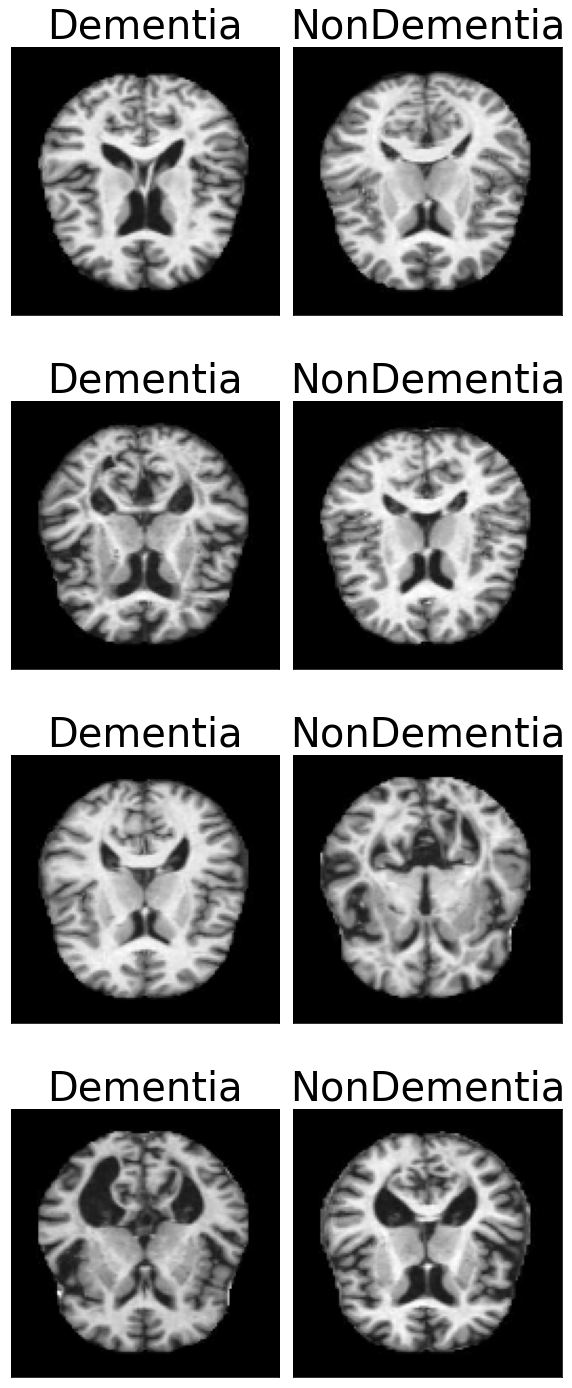

In [14]:
imgs = []
for i in range(n_class):
    imgs.append(x_val[y_val[:,i].astype(bool)][:n_sample])

imgs = np.array(imgs)
subplot_args = { 'nrows': n_sample, 'ncols': n_class,
                 'figsize': (int(4*n_class),int( 5*n_sample)),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

subplot_args2 = { 'nrows': 1, 'ncols': n_class,
                 'figsize': (int(4*n_class),5),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

f, ax = plt.subplots(**subplot_args)
for i in range(n_class):
  for j in range(n_sample):
    title = lbl_map[i]
    ax[j,i].set_title(title, fontsize=40)
    ax[j,i].imshow(imgs[i,j,:,:,0],cmap='gray')
plt.tight_layout()
# plt.savefig(prefix+'samples.jpg',dpi=150)
# plt.close()

In [4]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.03,
#   brightness_range=0.01,
#   shear_range=0.0,
    zoom_range=0.03,
#   horizontal_flip=True,
#   vertical_flip=True,
    fill_mode="nearest")
describe_labels(y,verbose=1)
x_us,y_us = balance_aug(x,y,trainAug)
# x_us,y_us = mixup(x,y,alpha=20,beta=1)
n_class,class_labels, nums = describe_labels(y_us,verbose=1)
x_us,y_us = shuffle_data(x_us,y_us)

print(x_us.shape,y_us.shape)

labels/numbers are:
 0    /  2379
 1    /  2436

labels/numbers are:
 0    /  2436
 1    /  2436

(4872, 128, 128, 1) (4872, 2)


In [7]:
tf.keras.backend.clear_session()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                             initial_learning_rate=1e-3,
                             decay_steps=100,
                             decay_rate=0.95)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
#opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
loss = tf.keras.losses.CategoricalCrossentropy()

In [8]:
# if LOSSF==0:
#     optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# elif LOSSF==1:
#     optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
# elif LOSSF==2:
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# elif LOSSF==3:
#     optimizer = tf.keras.optimizers.Adadelta(learning_rate=lr_schedule)
# elif LOSSF==4:
#     optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
# elif LOSSF==5:
#     optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_schedule)
# elif LOSSF==6:
#     optimizer = tf.keras.optimizers.Nadam(learning_rate=lr_schedule)
# elif LOSSF==7:
#     optimizer = tf.keras.optimizers.Ftrl(learning_rate=lr_schedule)

# model.reset_states() 


In [9]:
print('[INFO] building neural net...')
# initialize the initial learning rate, number of epochs to train for,
# and batch size

model = build_2dcond_model(shape=(lx0,ly0,1),
                           n_class=n_class,loss=loss,opt=opt,
                           n_layers = DEEP,
                           nch = 8,
                           kernelsize=3,
                           activation="relu",
                           maxpool=2)

# train the head of the network
print("[INFO] training ...")
H = model.fit(trainAug.flow(x_us, y_us, batch_size=BS),
              steps_per_epoch=len(x) // BS,
              epochs=EPOCHS,
              validation_data=(x_val, y_val),
# 	              callbacks=callbacks,
              verbose=0)

model.save(prefix+'model.h5', save_format="h5")

print('[INFO] trained model is saved.')

[INFO] building neural net...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 8)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 16)      1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 8)         1160      
_________________________________________________________________
conv2d_4 (Conv2D)            (N

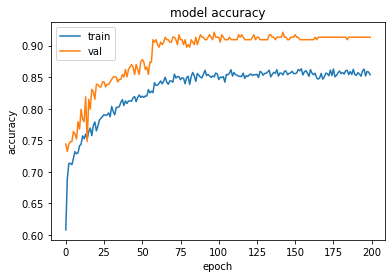

In [31]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(prefix+'train.jpg')
# plt.close()

In [10]:
model = load_model(prefix+'model.h5')
# print('[INFO] trained model is loaded.')
# print('[INFO] model summary is:\n\n')
# model.summary()

In [11]:
navg = x_us.shape[0]
navg = 10

y_p = np.zeros(y_us.shape)
for i in range(0,navg):
    y_p[i] = model.predict(x_us[i:i+1])
    
np.savez(prefix+'predict',y_us=y_us,y_p=y_p)

In [37]:
corrects = np.sum((y_us-y_p)**2,axis=1)<0.3

In [ ]:
y_val[:,i]

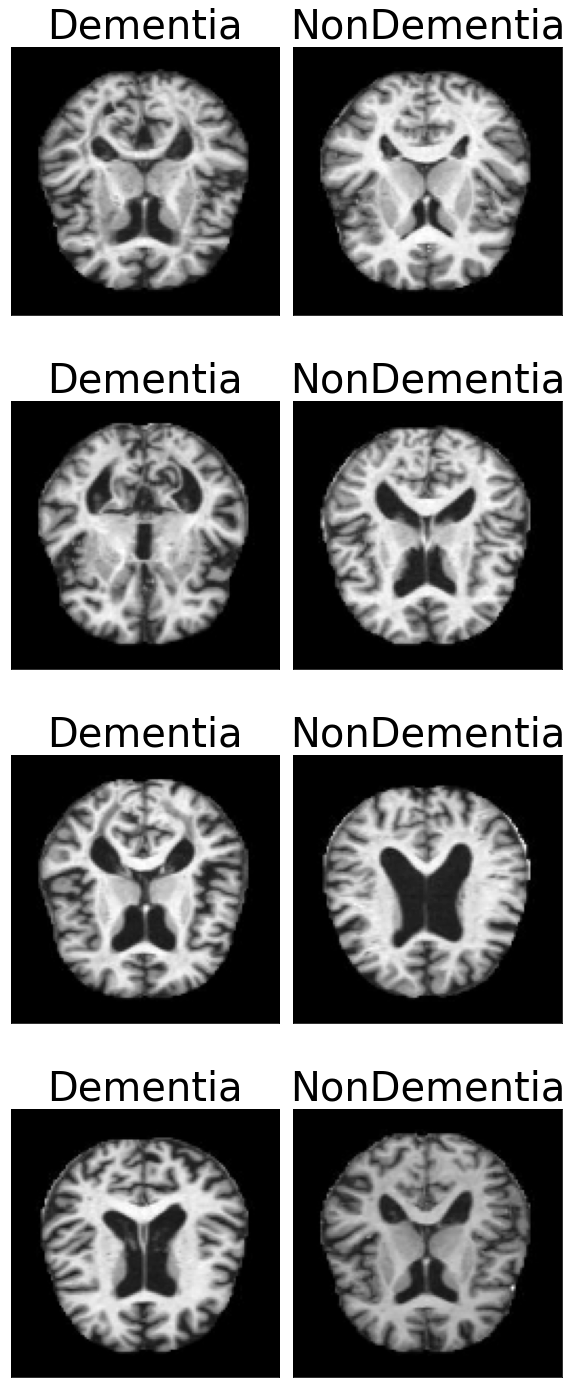

In [42]:
imgs = []
for i in range(n_class):
    filt = y_us[:,i].astype(bool)
    filt = corrects & filt
    imgs.append(x_us[filt][:n_sample])
imgs = np.array(imgs)

f, ax = plt.subplots(**subplot_args)
for i in range(n_class):
  for j in range(n_sample):
    title = lbl_map[i]
    ax[j,i].set_title(title, fontsize=40)
    ax[j,i].imshow(imgs[i,j,:,:,0],cmap='gray')
plt.tight_layout()
# plt.savefig(prefix+'samples.jpg',dpi=150)
# plt.close()

## Vanilla Saliency


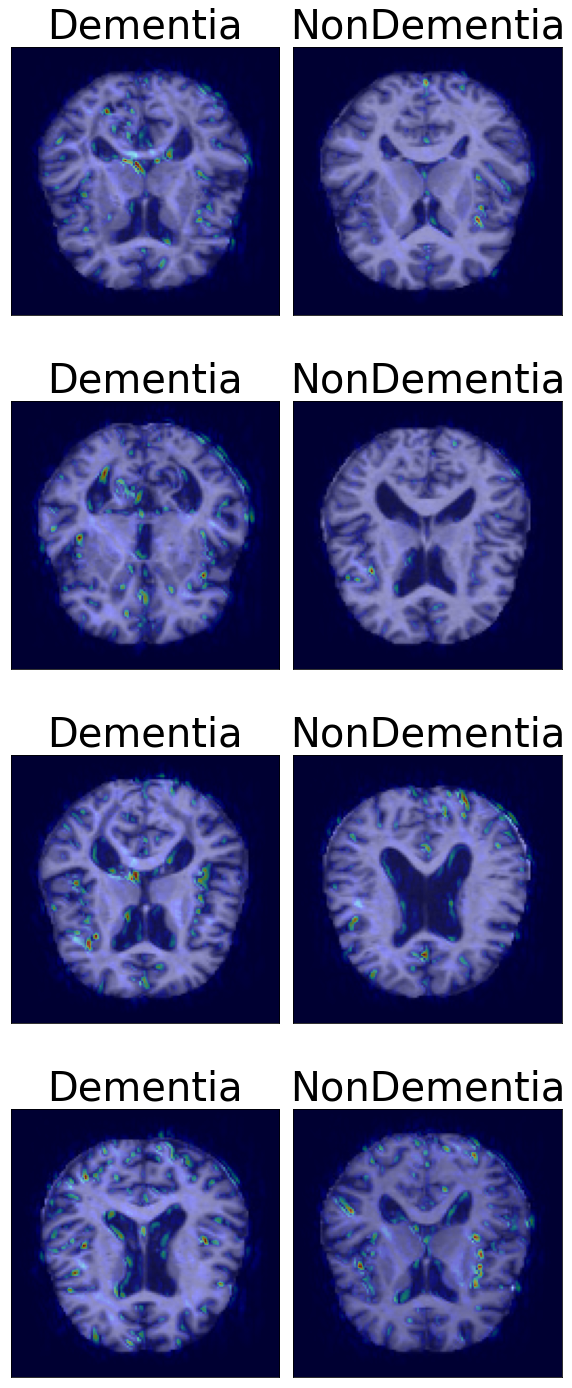

In [43]:
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

saliency_maps = []
for i in range(n_class):
    imgsp = imgs[i]
    loss = loss_maker(i)
    saliency_map = saliency(loss, imgsp)
    saliency_map = normalize(saliency_map)
    saliency_maps.append(saliency_map)
saliency_maps = np.array(saliency_maps)

f, ax = plt.subplots(**subplot_args)
for i in range(n_class):
  for j in range(n_sample):
    title = lbl_map[i]
    ax[j,i].set_title(title, fontsize=40)
    ax[j,i].imshow(imgs[i,j,:,:,0],cmap='gray')
    ax[j,i].imshow(saliency_maps[i,j], cmap='jet',alpha=0.4)
plt.tight_layout()
# plt.savefig(prefix+'vanilla_saliency_samples.jpg',dpi=dpi)
# plt.close()

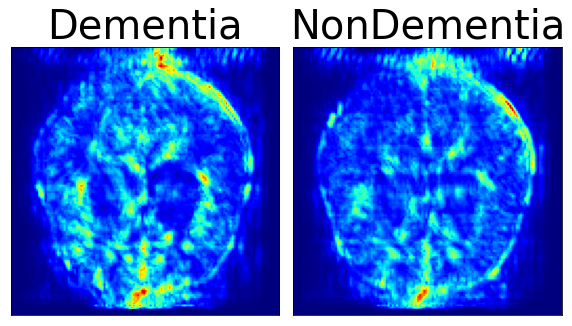

In [44]:
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)
saliency_maps = np.zeros(x_us.shape[:-1])
for i in range(0,navg):
    loss = loss_maker(np.argmax(y_us[i]))
    saliency_maps[i] = saliency(loss, x_us[i])
    saliency_maps[i] = normalize(saliency_maps[i])
np.savez(prefix+'vanilla_saliency',maps=saliency_maps,labels=labels)

f, ax = plt.subplots(**subplot_args2)
for i in range(n_class):
    title = lbl_map[i]
    ax[i].set_title(title, fontsize=40)
    ax[i].imshow(np.mean(saliency_maps[y_us[:,i].astype(bool)],axis=0), cmap='jet')
plt.tight_layout()
# plt.savefig(prefix+'vanilla_saliency_avg.jpg',dpi=dpi)
# plt.close()

## SmoothGrad

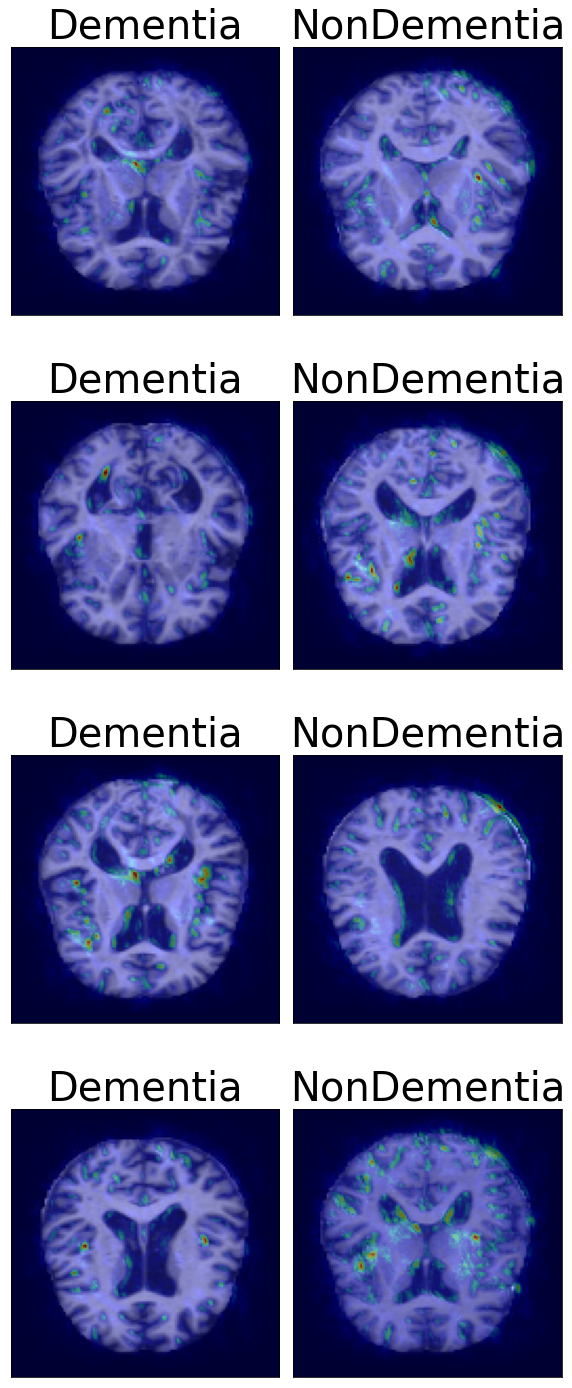

In [45]:
model = load_model(prefix+'model.h5')
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)
saliency_maps = []
for i in range(n_class):
    imgsp = imgs[i]
    loss = loss_maker(i)
    saliency_map = saliency(loss, imgsp,
                            smooth_samples=20,
                            smooth_noise=0.20)
    saliency_map = normalize(saliency_map)
    saliency_maps.append(saliency_map)
saliency_maps = np.array(saliency_maps)

f, ax = plt.subplots(**subplot_args)
for i in range(n_class):
  for j in range(n_sample):
    title = lbl_map[i]
    ax[j,i].set_title(title, fontsize=40)
    ax[j,i].imshow(imgs[i,j,:,:,0],cmap='gray')
    ax[j,i].imshow(saliency_maps[i,j], cmap='jet',alpha=0.4)
plt.tight_layout()
# plt.savefig(prefix+'smoothgrad_samples.jpg',dpi=dpi)
# plt.close()

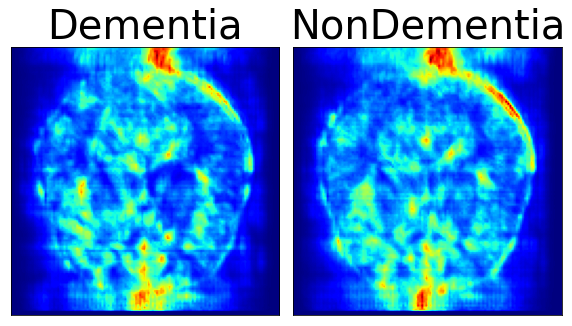

In [46]:
saliency_maps = np.zeros(x_us.shape[:-1])
for i in range(0,navg):
    loss = loss_maker(np.argmax(y_us[i]))
    saliency_maps[i] = saliency(loss, x_us[i],
                                smooth_samples=20, 
                                smooth_noise=0.20)
    saliency_maps[i] = normalize(saliency_maps[i])
np.savez(prefix+'smoothgrad',maps=saliency_maps,labels=labels)

f, ax = plt.subplots(**subplot_args2)
for i in range(n_class):
    title = lbl_map[i]
    ax[i].set_title(title, fontsize=40)
    ax[i].imshow(np.mean(saliency_maps[y_us[:,i].astype(bool)],axis=0), cmap='jet')
plt.tight_layout()
# plt.savefig(prefix+'smoothgrad_avg.jpg',dpi=dpi)
# plt.close()

## GradCAM

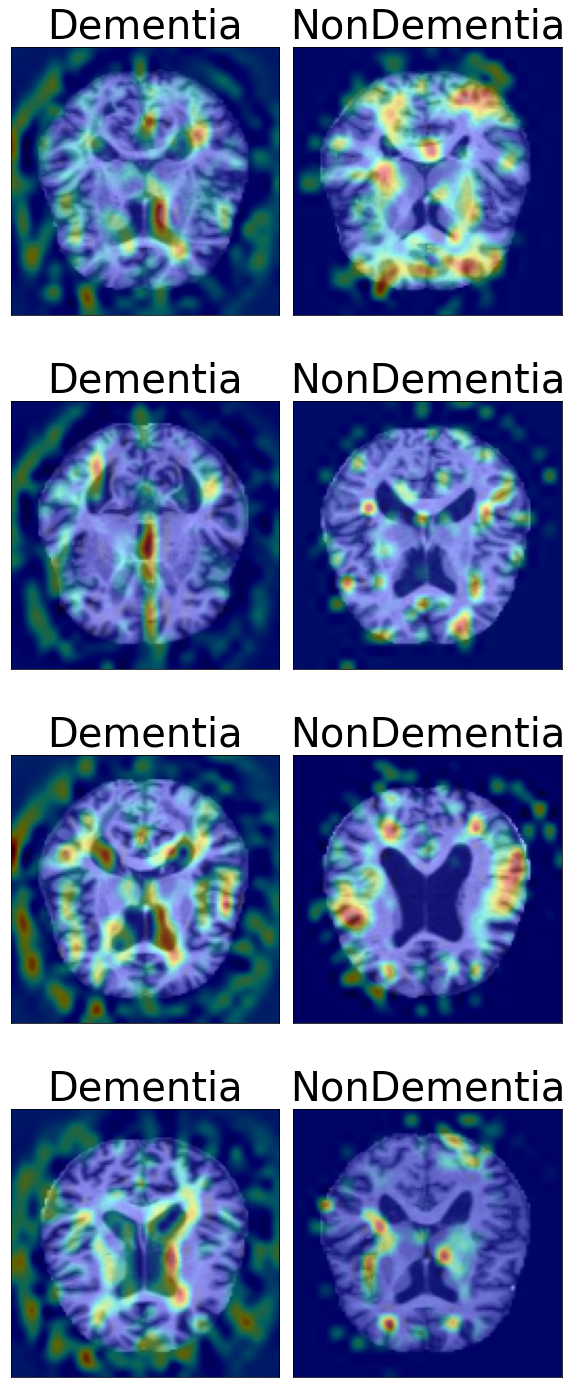

In [47]:
model = load_model(prefix+'model.h5')
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

saliency_maps = []
for i in range(n_class):
    imgsp = imgs[i]
    loss = loss_maker(i)
    saliency_map = gradcam(loss,imgsp,penultimate_layer=-1)
    saliency_map = normalize(saliency_map)
    saliency_maps.append(saliency_map)
saliency_maps = np.array(saliency_maps)

f, ax = plt.subplots(**subplot_args)
for i in range(n_class):
  for j in range(n_sample):
    title = lbl_map[i]
    ax[j,i].set_title(title, fontsize=40)
    ax[j,i].imshow(imgs[i,j,:,:,0],cmap='gray')
    heatmap = np.uint8(cm.jet(saliency_maps[i,j])[..., :3] * 255)
    ax[j,i].imshow(heatmap, cmap='jet',alpha=0.4)
plt.tight_layout()
# plt.savefig(prefix+'gradCAM_samples.jpg',dpi=dpi)
# plt.close()

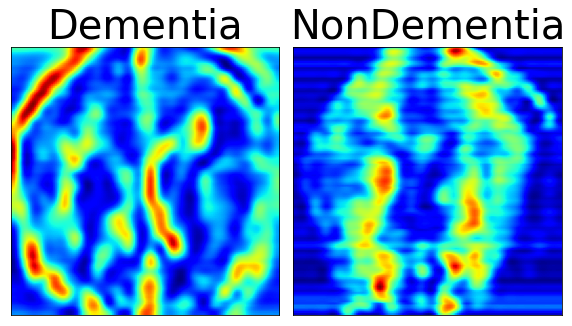

In [48]:
saliency_maps = np.zeros(x_us.shape[:-1])
for i in range(0,navg):
    loss = loss_maker(np.argmax(y_us[i]))
    saliency_maps[i] = gradcam(loss,x_us[i],penultimate_layer=-1)
    saliency_maps[i] = normalize(saliency_maps[i])
np.savez(prefix+'gradcam',maps=saliency_maps,labels=labels)

f, ax = plt.subplots(**subplot_args2)
for i in range(n_class):
    title = lbl_map[i]
    ax[i].set_title(title, fontsize=40)
    ax[i].imshow(np.mean(saliency_maps[y_us[:,i].astype(bool)],axis=0), cmap='jet')
plt.tight_layout()
# plt.savefig(prefix+'gradCAM_avg.jpg',dpi=dpi)
# plt.close()

## GradCAM++

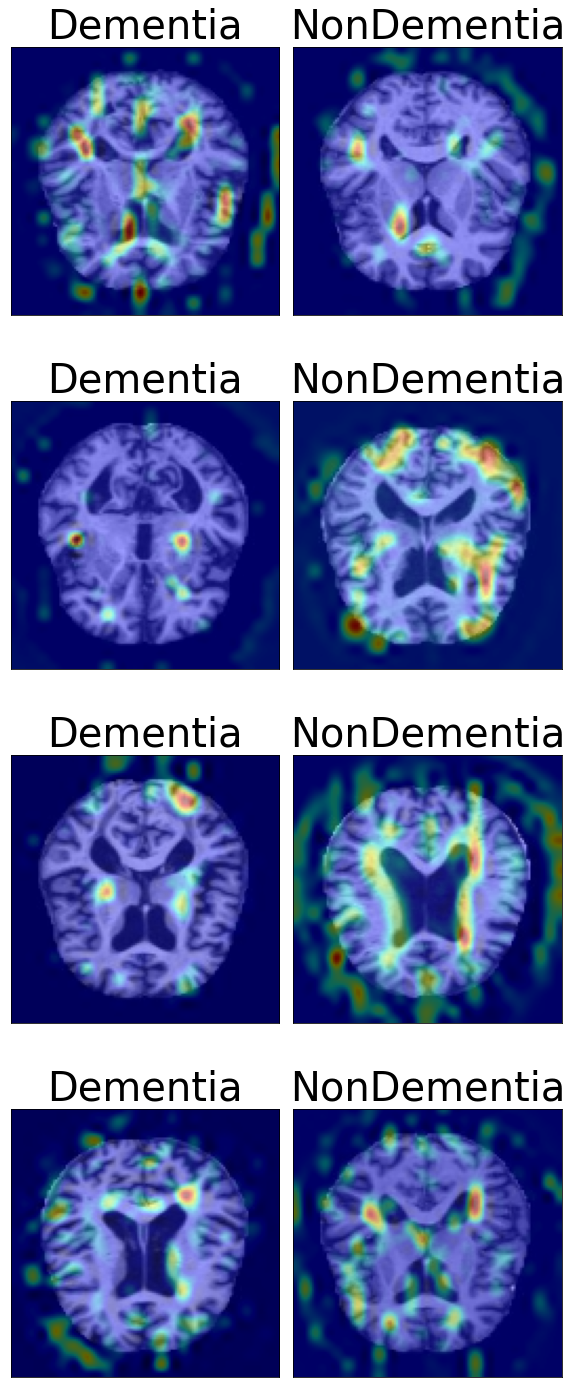

In [49]:
from tf_keras_vis.gradcam import GradcamPlusPlus

model = load_model(prefix+'model.h5')
gradcam = GradcamPlusPlus(model,
                          model_modifier=model_modifier,
                          clone=False)

saliency_maps = []
for i in range(n_class):
    imgsp = imgs[i]
    loss = loss_maker(i)
    saliency_map = gradcam(loss,imgsp,penultimate_layer=-1)
    saliency_map = normalize(saliency_map)
    saliency_maps.append(saliency_map)
saliency_maps = np.array(saliency_maps)

f, ax = plt.subplots(**subplot_args)
for i in range(n_class):
  for j in range(n_sample):
    title = lbl_map[i]
    ax[j,i].set_title(title, fontsize=40)
    ax[j,i].imshow(imgs[i,j,:,:,0],cmap='gray')
    heatmap = np.uint8(cm.jet(saliency_maps[i,j])[..., :3] * 255)
    ax[j,i].imshow(heatmap, cmap='jet',alpha=0.4)
plt.tight_layout()
# plt.savefig(prefix+'gradCAMpp_samples.jpg',dpi=dpi)
# plt.close()

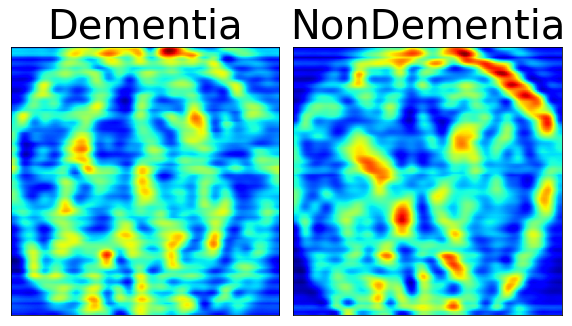

In [50]:
saliency_maps = np.zeros(x_us.shape[:-1])
for i in range(0,navg):
    loss = loss_maker(np.argmax(y_us[i]))
    saliency_maps[i] = gradcam(loss,x_us[i],penultimate_layer=-1)
    saliency_maps[i] = normalize(saliency_maps[i])
np.savez(prefix+'gradcampp',maps=saliency_maps,labels=labels)

f, ax = plt.subplots(**subplot_args2)
for i in range(n_class):
    title = lbl_map[i]
    ax[i].set_title(title, fontsize=40)
    ax[i].imshow(np.mean(saliency_maps[y_us[:,i].astype(bool)],axis=0), cmap='jet')
plt.tight_layout()
# plt.savefig(prefix+'gradCAMpp_avg.jpg',dpi=dpi)
# plt.close()

## ScoreCAM

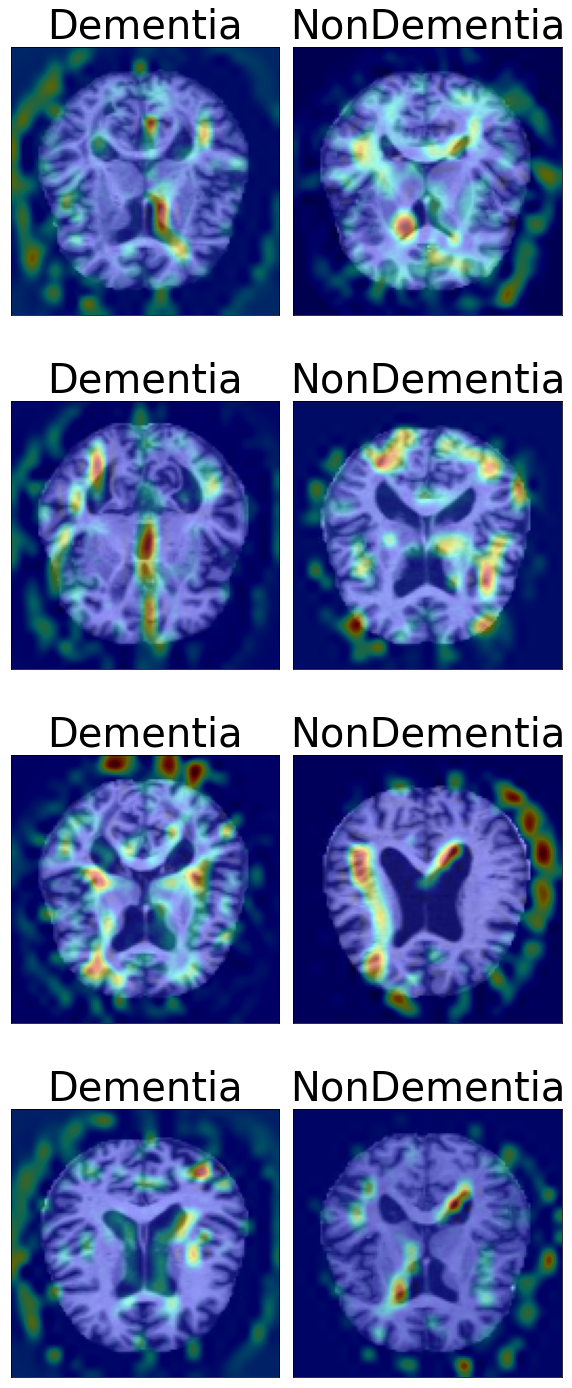

In [51]:
from tf_keras_vis.scorecam import ScoreCAM

model = load_model(prefix+'model.h5')
scorecam = ScoreCAM(model, model_modifier, clone=False)

saliency_maps = []
for i in range(n_class):
    imgsp = imgs[i]
    loss = loss_maker(i)
    saliency_map = scorecam(loss,imgsp,penultimate_layer=-1)
    saliency_map = normalize(saliency_map)
    saliency_maps.append(saliency_map)
saliency_maps = np.array(saliency_maps)

f, ax = plt.subplots(**subplot_args)
for i in range(n_class):
  for j in range(n_sample):
    title = lbl_map[i]
    ax[j,i].set_title(title, fontsize=40)
    ax[j,i].imshow(imgs[i,j,:,:,0],cmap='gray')
#     heatmap = np.uint8(cm.jet(saliency_maps[i,j])[..., :3] * 255)
    ax[j,i].imshow(saliency_maps[i,j], cmap='jet',alpha=0.4)
plt.tight_layout()
# plt.savefig(prefix+'scoreCAM_samples.jpg',dpi=dpi)
# plt.close()

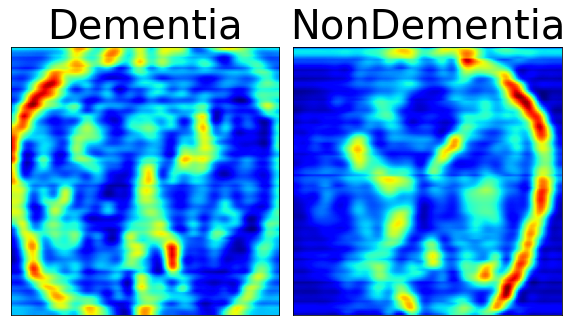

In [52]:
saliency_maps = np.zeros(x_us.shape[:-1])
for i in range(0,navg):
    loss = loss_maker(np.argmax(y_us[i]))
    saliency_maps[i] = scorecam(loss,x_us[i],penultimate_layer=-1)
    saliency_maps[i] = normalize(saliency_maps[i])
np.savez(prefix+'scorecam',maps=saliency_maps,labels=labels)

f, ax = plt.subplots(**subplot_args2)
for i in range(n_class):
    title = lbl_map[i]
    ax[i].set_title(title, fontsize=40)
    ax[i].imshow(np.mean(saliency_maps[y_us[:,i].astype(bool)],axis=0), cmap='jet')
plt.tight_layout()
# plt.savefig(prefix+'scoreCAM_avg.jpg',dpi=dpi)
# plt.close()

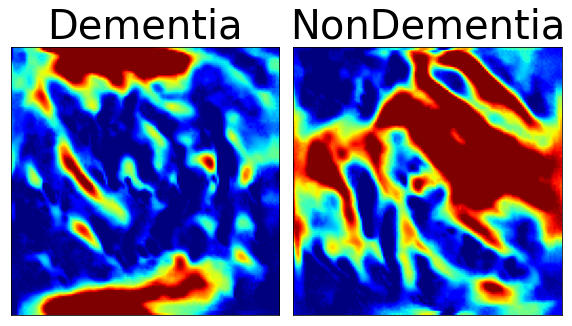

In [53]:
# # ActivationMaximization
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.callbacks import Print

model = load_model(prefix+'model.h5')
activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)
f, ax = plt.subplots(**subplot_args2)
for i in range(n_class):
    title = lbl_map[i]
    loss = loss_maker(i)
    seed_input = tf.random.uniform((1, lx0,ly0, 1), 0, 1)
    activation = activation_maximization(loss,
                                          seed_input=seed_input, # To generate multiple images
                                          steps=500,
#                                           callbacks=[Print(interval=50)],
                                        )
    ax[i].set_title(title, fontsize=40)
    ax[i].imshow(activation[0,:,:,0], cmap='jet')
plt.tight_layout()
# plt.savefig(prefix+'ActivationMaximization.jpg',dpi=dpi)
# plt.close()

# END

In [57]:
cycle_gan_model.saveit('model1/')

In [58]:
cycle_gan_model.loadit('model1/')

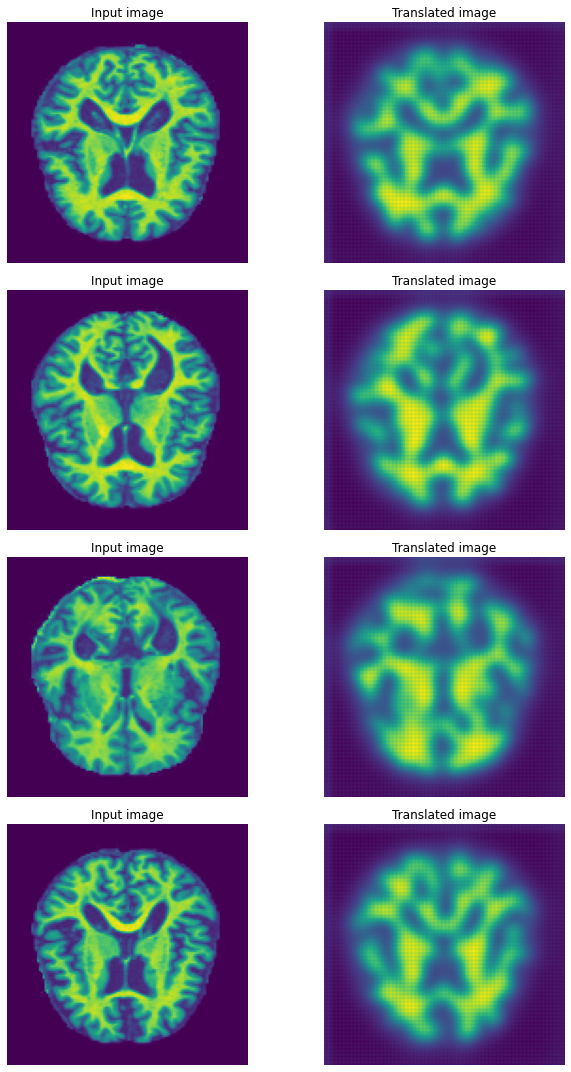

<Figure size 432x288 with 0 Axes>

In [59]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
#for i, img in enumerate(test_horses.take(4)):
for i in range(4):
    img = test_x0[i:i+1]
    prediction = np.array(cycle_gan_model.gen_G(img, training=False)[0])
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).astype(np.uint8) #.numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

plt.savefig('fig.jpg',dpi=150)


In [60]:
inds = np.argsort(np.mean(x,axis=(1,2,3)))

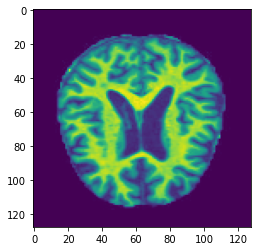

In [61]:
iii = inds[90]
plt.imshow(x[iii,:,:,0])

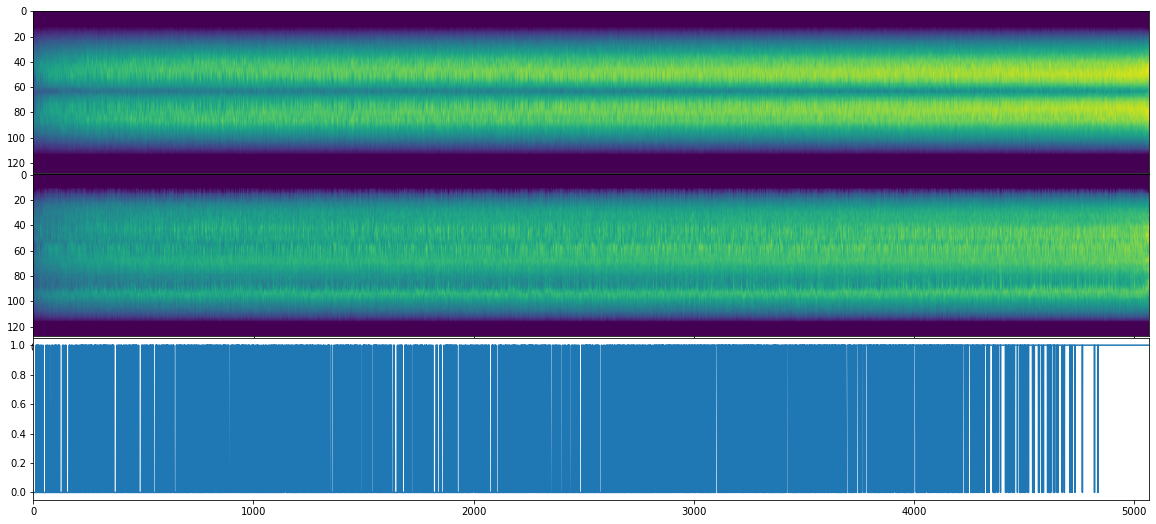

In [62]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,9))
ax1.imshow(np.mean(x[inds,:,:,0],axis=1).T,aspect='auto')
ax1.set_xticks([])
ax2.imshow(np.mean(x[inds,:,:,0],axis=2).T,aspect='auto')
ax1.set_xticks([])
ax3.plot(vec[inds])
ax3.set_xlim(0,x.shape[0])
plt.subplots_adjust(hspace=0.01)

In [87]:
x_us.dtype

dtype('float64')

In [88]:
x_us = x_us.astype(np.float32)
y_us = y_us.astype(np.float32)

In [90]:
# Put aside a few samples to create our validation set
BATCH_SIZE = BS

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_us, y_us))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_us, y_us))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

In [106]:
train_ds_one

<BatchDataset shapes: ((None, 128, 128, 1), (None, 2)), types: (tf.float32, tf.float32)>

In [237]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, 0.2, 0.2)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


def random_cut(ds,ll=64):
    # Unpack two datasets
    images, labels = ds
    batch_size,lx,ly,_ = tf.shape(images_one)

    # Sample lambda and reshape it to do the mixup
    xn = np.random.randint(0,lx-ll,batch_size)
    yn = np.random.randint(0,ly-ll,batch_size)
    
    imgs = []
    for i in range(batch_size):
        imgs.append(images[i,xn+ll,yn+ll,:])

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = np.array(imgs)
    return (images, labels)

In [242]:
train_ds

<ZipDataset shapes: ((<unknown>, <unknown>), (<unknown>, <unknown>)), types: ((tf.float32, tf.float32), (tf.float32, tf.float32))>

In [239]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),)

[1.0, 0.0]
[0.9951398968696594, 0.004860103130340576]
[0.262057900428772, 0.737942099571228]
[0.0, 1.0]
[9.202957153320312e-05, 0.9999079704284668]
[0.0, 1.0]
[1.0, 0.0]
[0.0, 1.0]
[0.9857321977615356, 0.014267802238464355]


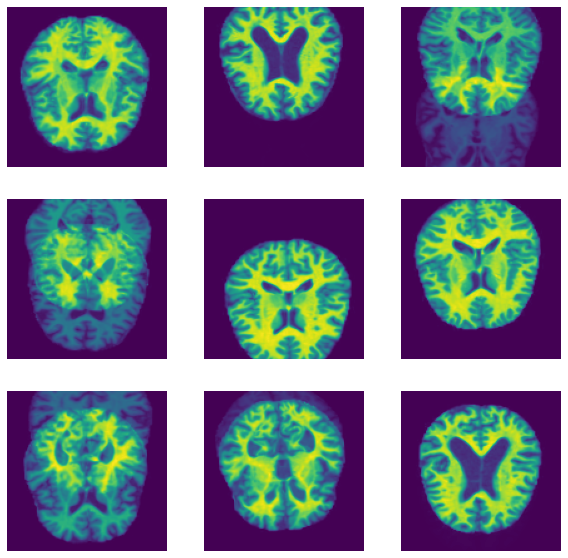

In [240]:


# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")


In [241]:
trainAug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.3,
#   brightness_range=0.01,
#   shear_range=0.0,
    zoom_range=0.03,
#   horizontal_flip=True,
#   vertical_flip=True,
    fill_mode="nearest")

def make_gen(x):
    def gen():
      i = 0
      while(i<len(x)):
        yield next(x)
        i +=1
    return gen

dflow1 = trainAug.flow(x_us, y_us, batch_size=BS)
dflow2 = trainAug.flow(x_us, y_us, batch_size=BS)

dflow1 = make_gen(dflow1)
dflow2 = make_gen(dflow2)

ds1 = tf.data.Dataset.from_generator(dflow1,output_types=(tf.float32,tf.float32))
ds2 = tf.data.Dataset.from_generator(dflow2,output_types=(tf.float32,tf.float32))

# ds2 = tf.data.Dataset.from_generator(dflow2,output_types=(tf.float32,tf.float32),
#                                      output_shapes=[(None,lx,ly,1),(None,2)])

train_ds = tf.data.Dataset.zip((ds1,ds2))
train_ds_mu = train_ds.map(lambda ds1, ds2: mix_up(ds1, ds2, alpha=0.2))   
# train_ds_mu = train_ds.map(lambda ds: ds)#random_cut(ds, alpha=64))                               

In [224]:
# dflow1 = trainAug.flow(x_us, y_us, batch_size=BS)
# dflow2 = trainAug.flow(x_us, y_us, batch_size=BS)

# dflow1 = make_gen(dflow1)
# dflow2 = make_gen(dflow2)

# ds1 = tf.data.Dataset.from_generator(dflow1,output_types=(tf.float32,tf.float32))
# ds2 = tf.data.Dataset.from_generator(dflow2,output_types=(tf.float32,tf.float32))

# # ds1 = tf.data.Dataset.from_generator(dflow1,output_types=(tf.float32,tf.float32),
# #                                      output_shapes=(tf.TensorShape((None, 128, 128, 1)), tf.TensorShape(None)))
# # ds2 = tf.data.Dataset.from_generator(dflow2,output_types=(tf.float32,tf.float32),
# #                                      output_shapes=(tf.TensorShape((None, 128, 128, 1)), tf.TensorShape(None)))

# train_ds = tf.data.Dataset.zip((ds1,ds2))
# # train_ds_mu = train_ds.map(lambda ds1, ds2: mix_up(ds1, ds2, alpha=0.2))
# train_ds_mu = train_ds.map(lambda ds1, ds2: ds1)


[0.9292031526565552, 0.07079685479402542]
[0.8474373817443848, 0.15256258845329285]
[0.5966663956642151, 0.4033336043357849]
[0.0, 1.0]
[0.7888724207878113, 0.21112759411334991]
[0.9943898320198059, 0.005610167980194092]
[0.04719635471701622, 0.9528036713600159]
[0.02434253692626953, 0.9756574630737305]
[0.0, 1.0]


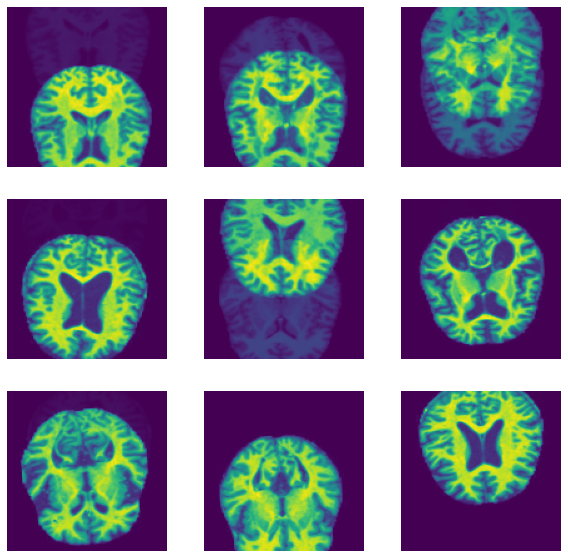

In [243]:
# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")


In [212]:
x20 = []
for sample_images, sample_labels in train_ds_mu:
    print(sample_images.shape,sample_labels.shape)
    break
    x20.append(sample_images)

(32, 128, 128, 1) (32, 2)


In [181]:
x_us.shape

(5120, 128, 128, 1)

In [219]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

l1 = 0.01
n_class = 2

input_img = keras.Input(shape=(128, 128, 1))
labels = keras.Input(shape=(2,))
wieghts = keras.Input(shape=())

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
#     print(sh)
x = layers.Flatten()(x)

output = layers.Dense(n_class, activation='sigmoid',
            activity_regularizer=regularizers.l1(l1))(x)

model = keras.Model(input_img, output, name='encoder')
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["acc"])

In [220]:
# dflow1 = trainAug.flow(x_us, y_us, batch_size=BS)


model.fit(train_ds_mu.as_numpy_iterator(),batch_size=32)

160/160 [==============================] - 14s 81ms/step - loss: 123.0968 - acc: 0.5138


In [201]:
model.fit(train_ds_mu,batch_size=512)

AttributeError: 'MapDataset' object has no attribute 'batch_size'

In [190]:
dflow1

In [198]:
train_ds_mu.as_numpy_iterator()